# Cтратегия взаимодействия с клиентами Сеть фитнес-центров «Культурист-датасаентист» 

**Цель исследования:** Сформулировать предложения по снижению оттока клиентов.

**Критерий оттока клиента:** Клиент попал в отток, если за последний месяц ни разу не посетил спортзал.

**План исследования:**
1) Загрузим данные и проведем их предобработку;<br>
2) Проведем исследовательский анализ данных; <br>
3) Построим модель прогнозирования оттока клиентов; <br>
4) Сделаем кластеризацию клиентов; <br>
5) Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами.

**Инструменты:** Заказчик подготовил информацию в csv-файлах на основе клиентских анкет, которые содержат данные на месяц до оттока и факт оттока на определённый месяц.

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage 

## Загрузка данных

Прочитаем данные из файла, сохраним в переменную df и выведем первые 5 строк.

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Далее получим общее представление о датафрейме с помощью метода info().

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Пропущенных значенией нет.

Переведем названия столбцов в нижний регистр для удобства дальнейшей работы с ними.

In [4]:
df.columns = df.columns.str.lower()

Признаки 'gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'churn' - категориальные, остальные - числовые.

In [5]:
categoriсal_signs = ['gender', 'near_location', 'partner', 'promo_friends', \
                'phone', 'contract_period', 'group_visits', 'churn']

In [6]:
number_signs_list = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', \
                'avg_class_frequency_total', 'avg_class_frequency_current_month']

Проверим категориальные признаки на корректность заполнения.

In [7]:
for elem in df[categoriсal_signs].columns:
    print(df[elem].value_counts())

1    2041
0    1959
Name: gender, dtype: int64
1    3381
0     619
Name: near_location, dtype: int64
0    2053
1    1947
Name: partner, dtype: int64
0    2766
1    1234
Name: promo_friends, dtype: int64
1    3614
0     386
Name: phone, dtype: int64
1     2207
12     960
6      833
Name: contract_period, dtype: int64
0    2351
1    1649
Name: group_visits, dtype: int64
0    2939
1    1061
Name: churn, dtype: int64


Видимых проблем и лишних значений нет.

Изучим средние значения и стандартные отклонения для количественных признаков.

In [8]:
df[number_signs_list].describe()

,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052
std,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906
min,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000
25%,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003
50%,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574
75%,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336
max,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783


Значительных выбросов нет, данные выглядят корректно.

Проверим датафрейм на наличие явных дубликатов.

In [9]:
df.duplicated().sum()

0

**Вывод:** Имеем данные, состоящие из 4000 строк. Пропущенных значений и дубликатов нет. Выбросов нет. Переходим к следующему этапу.

## Исследовательский анализ данных

Изучим  средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [10]:
df.groupby('churn').mean().reset_index()

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Для большей наглядности построим столбчатые гистограммы распределения признаков тех клиентов, которые попали в отток и тех, кто остался.

Сначала изучим распределения количественных признаков.

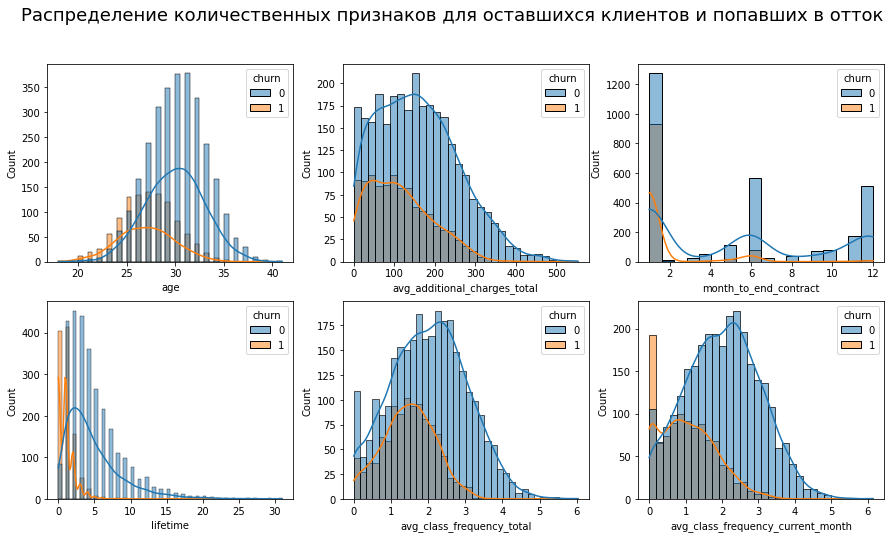

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
ax=ax.ravel()
fig.suptitle('Распределение количественных признаков для оставшихся клиентов и попавших в отток', fontsize = 18)
for i in range(len(number_signs_list)):
    sns.histplot(df, x=df[number_signs_list[i]], hue='churn', ax=ax[i], kde=True)
plt.show()

Первые выводы, которые можно сделать, глядя на эти графики:<br>
1) Клиенты, не попавшие в отток в среднем тратят больше денег на доп. услуги;<br>
2) Клиенты, не попавшие в отток дольше посещают фитнес-центр;<br>
3) Клиенты не попавшие в отток чаще посещают фитнес-центр.<br>

Теперь изучим, как распределены категориальные признаки.

Для корректного построения гистограмм временно приведем категориальные признаки к формату строки.

In [12]:
df[categoriсal_signs] = df[categoriсal_signs].astype('str')

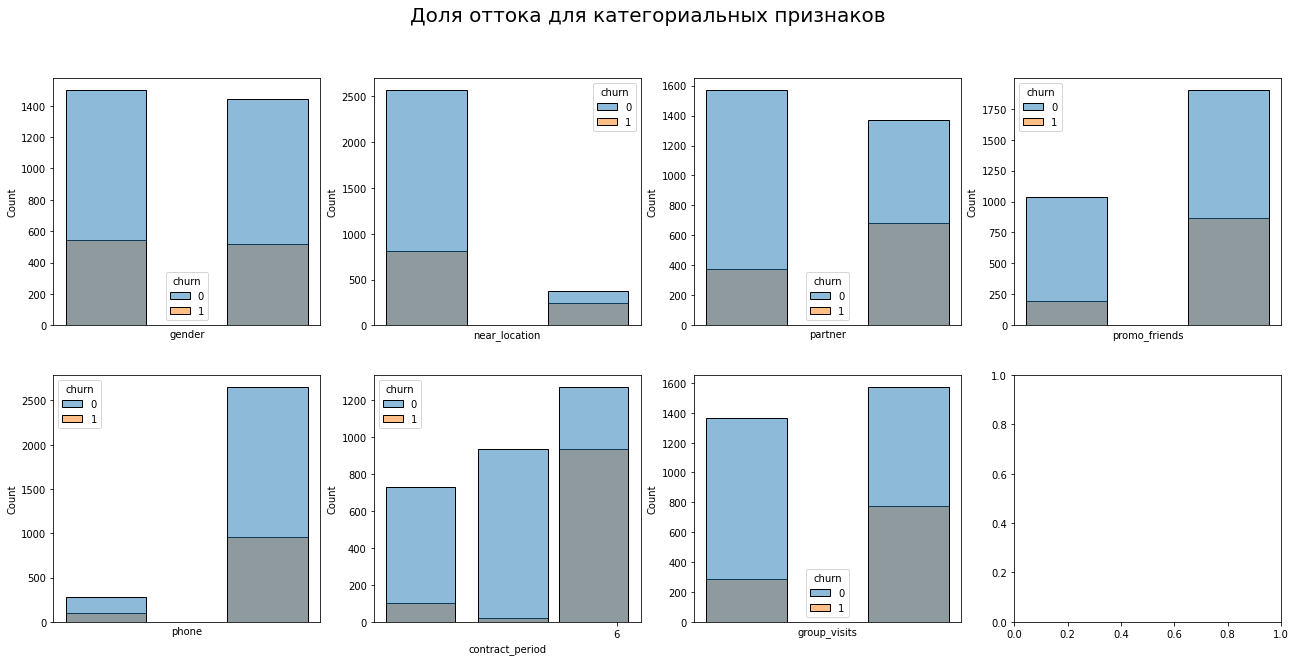

In [13]:
fig, ax = plt.subplots(2, 4, figsize=(22, 10))
fig.suptitle('Доля оттока для категориальных признаков', fontsize = 20)
ax=ax.ravel()
for i in range(len(categoriсal_signs)-1):
    sns.histplot(df, x=categoriсal_signs[i], hue='churn', ax=ax[i], discrete=False, shrink=6)

plt.show()

Можно сделать вывод, что на факт оттока влияют следующие категориальные признаки:<br>
1) Расположен ли фитнес-центр близко от дома клиента;<br>
2) Является ли клиент сотрудником компании-партнера;<br>
3) Пришел ли клиент по акции "Приведи друга";<br>
4) Срок абонемента;<br>
5) Факт посещения групповых занятий.

In [14]:
# Обратно переведем значения категориальных признаков к формату int
df[categoriсal_signs] = df[categoriсal_signs].astype('int')

Построим матрицу корреляции.

Text(0.5, 1.0, 'Матрица корреляции признаков')

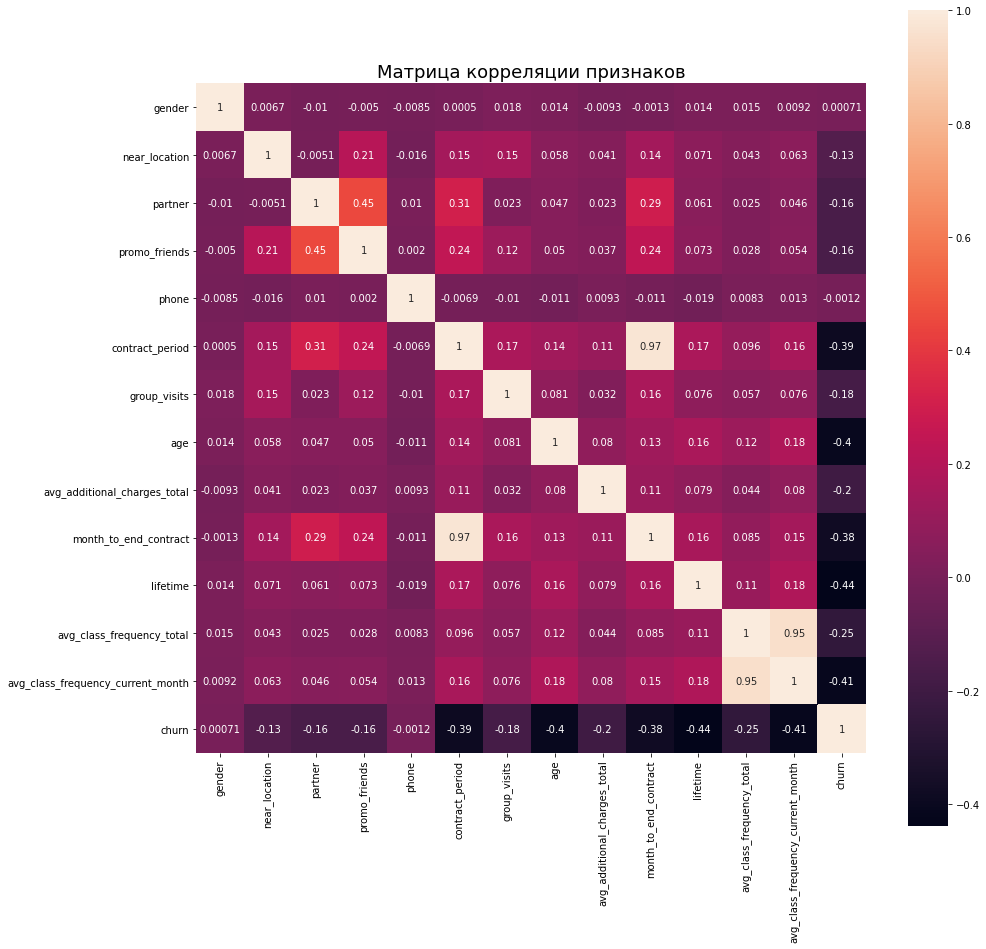

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, square=True)
plt.title('Матрица корреляции признаков', fontsize = 18)

Матрица корреляции не показала значимых значений для целевой переменной. Между собой сильно коррелируют признаки "частота посещений с начала действия абонемента" и "частота посещений в текущем месяце", но это и так достаточно очевидно.

**Вывод:**<br> Построив гистограммы, выяснили, что на факт оттока влияют следующие признаки:<br>
1) Суммарная выручка от других услуг фитнес-центра;<br>
2) Время с момента первого обращения в фитнес-центр;<br>
3) Средняя частота посещений в неделю (за последний месяц и с начала действия абонемента);<br>
4) Проживание или работа в районе, где находится фитнес-центр;<br>
5) Является ли клиент сотрудником компании-партнера;<br>
6) Пришел ли клиент по акции "Приведи друга";<br>
7) Срок абонемента;<br>
8) Факт посещения групповых занятий.<br>

Далее построим модель прогнозирования оттока клиентов.

## Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

Разделим выборку на обучающую и валидационную в отношении 80/20.

In [16]:
X = df.drop('churn', axis=1)
y = df['churn']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Обучение модели методом логистической регрессии

In [18]:
lr_model = LogisticRegression(solver='liblinear', random_state=0)

In [19]:
# Обучаем модель
lr_model.fit(X_train, y_train)
# Делаем предсказания
lr_predictions = lr_model.predict(X_test)
# Определяем вероятность принадлежности к классу 0 или 1
lr_probabilities = lr_model.predict_proba(X_test)[:, 1]

In [20]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, lr_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, lr_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, lr_predictions)))

Accuracy: 0.93
Precision: 0.86
Recall: 0.83
F1: 0.85


### Обучение модели методом случайного леса

In [21]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)

In [22]:
# Обучаем модель
rf_model.fit(X_train, y_train)
# Делаем предсказания
rf_predictions = rf_model.predict(X_test)
# Определяем вероятность принадлежности к классу 0 или 1
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

In [23]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))

Accuracy: 0.92
Precision: 0.84
Recall: 0.82
F1: 0.83


**Вывод:** Оба метода показали достаточно высокие оценки метрик.
Метод логистической регресии показал себя немного лучше, чем метод случайного леса. 

## Кластеризация пользователей

Сперва необходимо выполнить стандартизацию данных.

In [24]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

In [25]:
X_test_st = scaler.transform(X_test)

Построим матрицу расстояний и нарисуем дендрограмму.

In [26]:
linked = linkage(X_train_st, method = 'ward') 

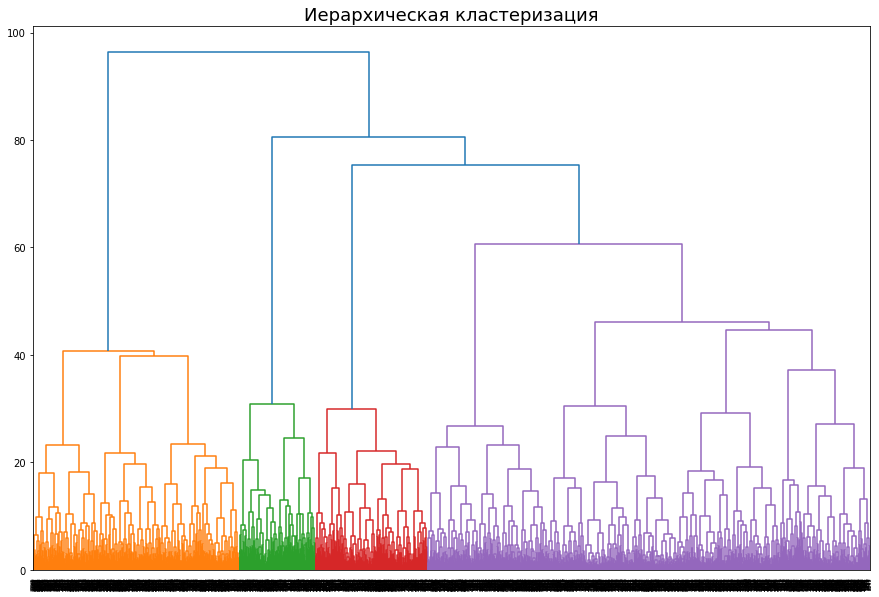

In [27]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация', fontsize = 18)
plt.show()

На полученной дендрограмме видно, что можно выделить четыре кластера (4 разных цвета), но будем руководствоваться условиями задачи и примем количество кластеров равным пяти.

Обучим модель кластеризации алгоритмом K-Means.

In [28]:
km = KMeans(n_clusters=5, random_state=0)
# Прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X)

In [29]:
# Добавим значение кластера в датафрейм
df['cluster_km'] = labels

Изучим средние значения признаков для кластеров.

In [30]:
df_clusters = df.groupby('cluster_km').mean().reset_index()
df_clusters

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,0,0.514091,0.839650,0.451895,0.279883,0.897959,4.301263,0.407191,28.973761,105.932804,3.996113,3.544218,1.852564,1.708264,0.334305
1,1,0.511435,0.844075,0.495842,0.320166,0.902287,4.755717,0.423077,29.401247,174.873445,4.376299,3.749480,1.895200,1.785569,0.226611
2,2,0.468635,0.856089,0.516605,0.332103,0.926199,5.822878,0.431734,29.845018,356.481960,5.383764,4.420664,2.019260,2.009382,0.044280
3,3,0.508721,0.824612,0.488372,0.293605,0.907946,4.198643,0.387597,28.908915,35.600722,3.855620,3.394380,1.836755,1.692641,0.349806
4,4,0.521246,0.881020,0.511331,0.347025,0.898017,5.400850,0.433428,29.344193,250.984767,5.001416,4.169972,1.903480,1.843255,0.178470


Среднее значение признака "Суммарная выручка от других услуг фитнес-центра" для кластеров 2 и 4 сильно отличается от других кластеров. По этим же кластерам имеем наименьшую долю клиентов, ушедших в отток.

Для наглядности построим распределения признаков для кластеров.

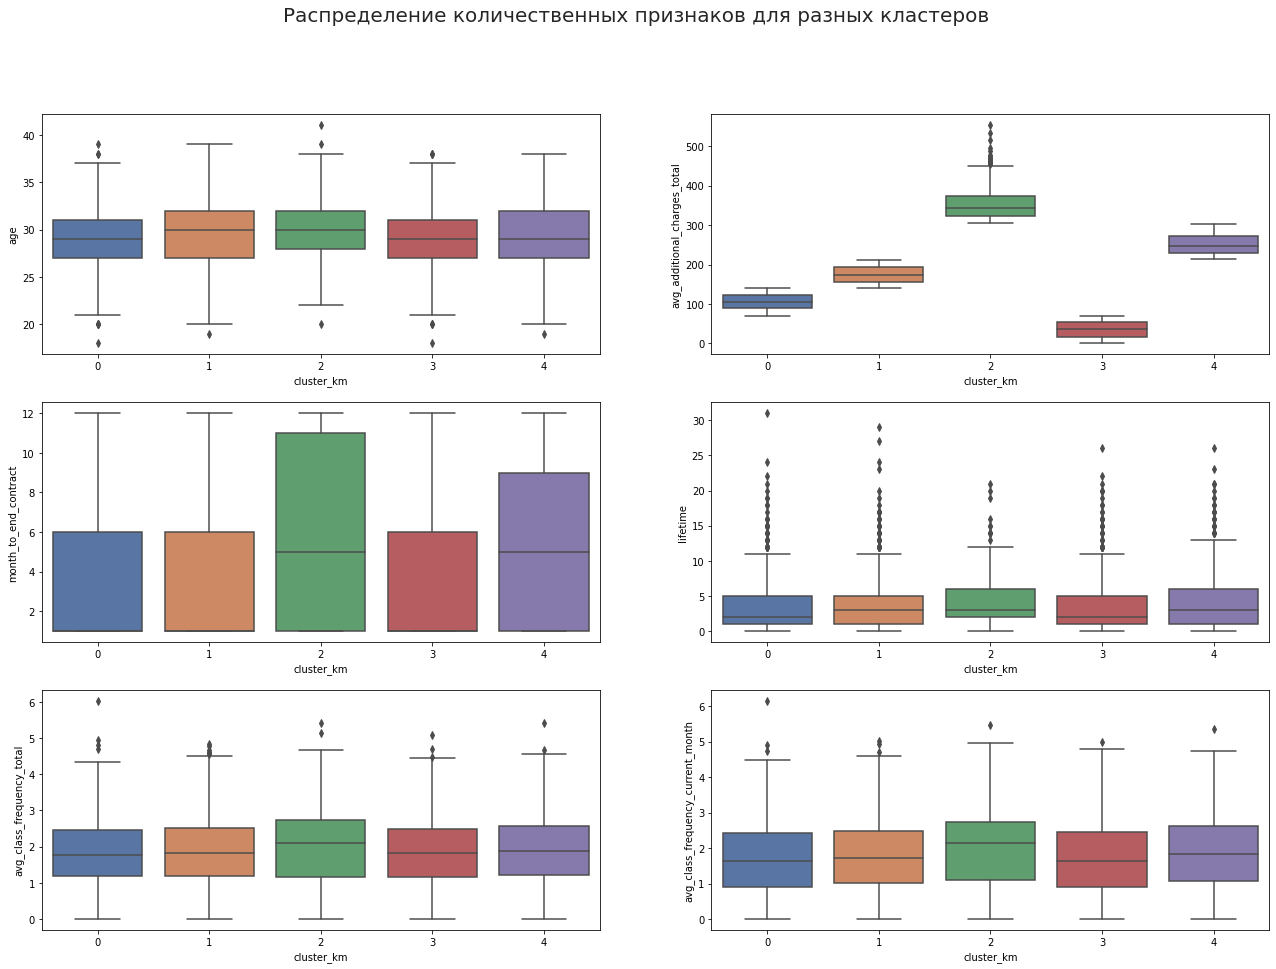

In [31]:
fig, ax = plt.subplots(3, 2, figsize=(22, 15))
ax=ax.ravel()
sns.set_theme(style="whitegrid")

for i in range(len(number_signs_list)):
    sns.boxplot(x="cluster_km", y=number_signs_list[i], ax=ax[i], data=df)
    
fig.suptitle('Распределение количественных признаков для разных кластеров', fontsize = 20)
plt.show()   

На этих графиках видно, что модель придает большое значение признаку "Суммарная выручка от других услуг фитнес-центра". Распределение других признаков примерно одинаковое. 

## Общий вывод:

1) С помощью исследовательского анализа данных выяснили, что на факт оттока влияют следующие признаки:<br>
- Суммарная выручка от других услуг фитнес-центра;<br>
- Время с момента первого обращения в фитнес-центр;<br>
- Средняя частота посещений в неделю (за последний месяц и с начала действия абонемента);<br>
- Проживание или работа в районе, где находится фитнес-центр;<br>
- Является ли клиент сотрудником компании-партнера;<br>
- Пришел ли клиент по акции "Приведи друга";<br>
- Срок абонемента;<br>
- Факт посещения групповых занятий.<br>

2) Методом логистической регрессии построили модель предсказания оттока клиента с достаточно высокими метриками (Accuracy: 0.93
Precision: 0.86, Recall: 0.83, F1: 0.85)<br>

3) Методом K-Means спрогнозировали кластеры клиентов. Выяснили, что модель придает большое значение признаку "Суммарная выручка от других услуг фитнес-центра". Те, кто больше тратит на дополнительные услуги фитнес-центра, реже попадают в отток.

**Рекомендации:**
1) Необходимо мотивировать клиентов пользоваться дополнительными услугами фитнес-центра, например, дарить дополнительные месяцы, если клиент активно пользуется дополнительными услугами. Стоит подумать о расширении ассортимента дополнительных услуг;<br>
2) Вероятность того, что клиент останется выше, если он покупает абонемент на длительное время. Необходимо мотивировать клиента на покупку абонемента сразу на год с помощью ценовой политики или улучшить работу менеджеров по продажам; <br>
3) Продолжать и расширять работу с компаниями-партнерами;<br>
4) Продолжать и расширять акцию "Приведи друга";<br>
5) Мотивировать клиентов приходить на групповые занятия. <br>